Stock investing Example, application of the reduction property

In [3]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [4]:
import yfinance as yf
import itertools

In [5]:
rng = np.random.default_rng()

In [6]:
from robust_q_learning_v2 import *
from q_learning import *

Importation of market data from yahoo finance

In [7]:
# AAPL_data  = yf.download("AAPL", start="2010-01-02", end="2021-01-01")
# MSFT_data  = yf.download("MSFT", start="2010-01-02", end="2021-01-01")
# GOOGL_data = yf.download("GOOGL", start="2010-01-02", end="2021-01-01")
# EBAY_data  = yf.download("EBAY", start="2010-01-02", end="2021-01-01")
# AMZN_data  = yf.download("AMZN", start="2010-01-02", end="2021-01-01")
# TSLA_data  = yf.download("TSLA", start="2010-01-02", end="2024-01-01")

data = yf.download("GOOGL", start="2010-01-02", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed


Computation of the return of the stock selected

In [8]:
small_return = 0.01
#null_return  = 0.001
#ind_0     = ((np.diff(data["Close"])/(data["Close"])[:-1])<null_return)&((np.diff(data["Close"])/(data["Close"])[:-1])>-null_return)

ind_0_pos = ((np.diff(data["Close"])/(data["Close"])[:-1]) <  small_return)&((np.diff(data["Close"])/(data["Close"])[:-1])>=0)
ind_pos   = ((np.diff(data["Close"])/(data["Close"])[:-1]) >= small_return)
ind_0_neg = ((np.diff(data["Close"])/(data["Close"])[:-1]) > -small_return)&((np.diff(data["Close"])/(data["Close"])[:-1])<=0)
ind_neg   = ((np.diff(data["Close"])/(data["Close"])[:-1]) <=-small_return)

returns = np.zeros(len(data)-1)
#returns[ind_0]     = 0
returns[ind_0_pos] =  1
returns[ind_pos]   =  2
returns[ind_0_neg] = -1
returns[ind_neg]   = -2

mr1 = np.mean((np.diff(data["Close"])/(data["Close"])[:-1])[ind_0_pos])
print(mr1*4)
mr2 = np.mean((np.diff(data["Close"])/(data["Close"])[:-1])[ind_pos])
print(mr2)

0.01844430165574956
0.021118415930247488


Definition of training and testing periods

In [9]:
training_start = 1_000
training_end   = 1_500
returns_train_1  = returns[training_start:training_end]

training_start = 2_500
training_end   = 3_000
returns_train_2  = returns[training_start:training_end]

training_start = 3_000
training_end   = 3_500
returns_train_3  = returns[training_start:training_end]

#Testing Period
test_period_start = training_end+1
test_period_end = training_end+101
returns_test = returns[test_period_start:test_period_end]

In [10]:
returns_train_1

array([-1.,  1.,  1., -1.,  2., -1., -1.,  2.,  2.,  1., -1., -1., -1.,
        2., -1.,  1., -1.,  2.,  1., -1., -2., -2.,  2., -2.,  2.,  2.,
       -2.,  1.,  1.,  2.,  2., -1.,  2., -1.,  2.,  1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1., -1., -1., -2.,  2.,  1.,  1., -1., -1., -1.,
        1., -2., -2.,  2.,  2., -1., -1., -2., -2.,  1., -2., -2.,  1.,
       -1.,  2.,  1.,  1., -2., -1.,  2.,  2., -2., -2.,  2.,  1.,  2.,
       -2., -1.,  2., -2., -1., -2., -1.,  2., -1.,  1., -1.,  1., -2.,
       -1.,  1.,  2.,  2.,  1., -2., -1., -1.,  2.,  1.,  2.,  2.,  2.,
        2., -1.,  1.,  1., -2., -2., -1.,  2.,  1.,  1., -1., -1., -2.,
        1., -2., -1.,  2.,  1.,  1.,  2., -1.,  2., -1.,  1., -1.,  2.,
       -1.,  1., -1., -2.,  1., -1.,  2.,  2., -1., -1., -2.,  2., -2.,
        1.,  1., -1., -1.,  1., -1.,  1., -2., -2.,  2., -2.,  1., -1.,
        2., -1., -1.,  2.,  1., -1.,  2.,  1., -1., -1.,  1., -1., -1.,
       -1., -1.,  1.,  2.,  1.,  1.,  1.,  1., -2.,  1., -1., -2

Verification that the training periods correspond to really different periods

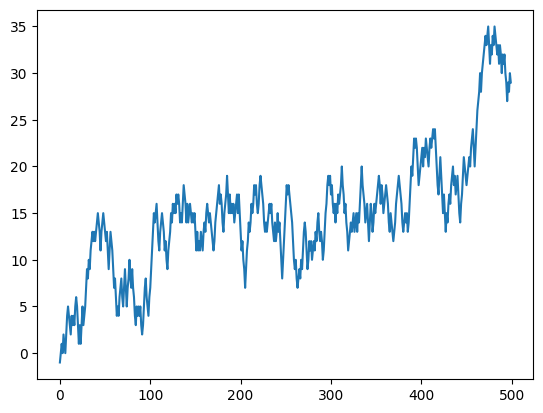

In [11]:
plt.plot(returns_train_1.cumsum())

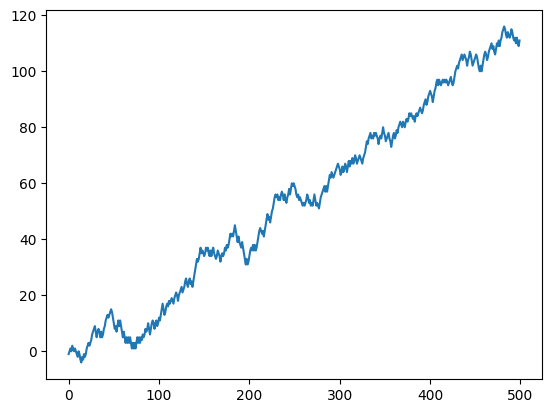

In [12]:
plt.plot(returns_train_2.cumsum())

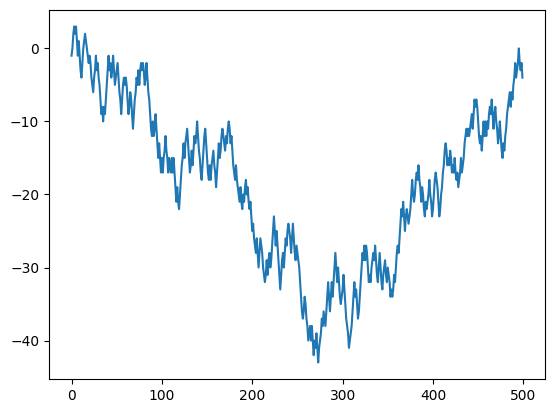

In [13]:
plt.plot(returns_train_3.cumsum())

In [14]:
h    = 5 # Length of history
ret1 = returns_train_1
ret2 = returns_train_2
ret3 = returns_train_3

#h2   = 4
#returns

Definition of the parameters to use the algorithm

In [15]:
# State Space
T = [-2, -1, 1, 2]
X = np.array(list(itertools.product(T, repeat=h)))
#X
#X2 = np.array(list(itertools.product(T, repeat=h2)))

In [16]:
A = np.array([0, 1]) # Actions

def r1(x,a,y):
    return ((abs(x[-1])==1) * 0.02 + (abs(x[-1])==2) * 0.01) * a * y[-1]
def r2(x,a,y):
    return 0.01 * a * y[-1]

eps_greedy = 0.1   # Epsilon greedy policy
alpha      = 0.95  # Discount Factor

#x_0        = 0     # Initial Value
rng  = np.random.default_rng()
x1_0 = rng.choice(np.array([ret1[i:(h+i)]  for i in range(len(ret1)-h-1)]),axis = 0)
x2_0 = rng.choice(np.array([ret2[i:(h+i)]  for i in range(len(ret2)-h-1)]),axis = 0)
x3_0 = rng.choice(np.array([ret3[i:(h+i)]  for i in range(len(ret3)-h-1)]),axis = 0)

k_0        = 0     # Initial index of the corresponding MDP, starting with the central proba of 1/2

In [17]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

For each x, computation of the probabilities of occurence of the next return

In [18]:
p1_list = []
for x in X:
    eps = 1e-8
    x_u  = np.concatenate([x[1:], [2]])
    x_d  = np.concatenate([x[1:], [-2]])
    x_u0 = np.concatenate([x[1:], [1]])
    x_d0 = np.concatenate([x[1:], [-1]])
    p_u_raw  = np.sum([np.all(ret1[i:(h+i)]==x_u) for i in range(len(ret1)-h-1)])
    p_d_raw  = np.sum([np.all(ret1[i:(h+i)]==x_d) for i in range(len(ret1)-h-1)])
    p_u0_raw = np.sum([np.all(ret1[i:(h+i)]==x_u0) for i in range(len(ret1)-h-1)])
    p_d0_raw = np.sum([np.all(ret1[i:(h+i)]==x_d0) for i in range(len(ret1)-h-1)])
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p1_list.append([p_d, p_d0, p_u0, p_u])

p2_list = []
for x in X:
    eps = 1e-8
    x_u  = np.concatenate([x[1:], [2]])
    x_d  = np.concatenate([x[1:], [-2]])
    x_u0 = np.concatenate([x[1:], [1]])
    x_d0 = np.concatenate([x[1:], [-1]])
    p_u_raw  = np.sum([np.all(ret2[i:(h+i)]==x_u) for i in range(len(ret2)-h-1)])
    p_d_raw  = np.sum([np.all(ret2[i:(h+i)]==x_d) for i in range(len(ret2)-h-1)])
    p_u0_raw = np.sum([np.all(ret2[i:(h+i)]==x_u0) for i in range(len(ret2)-h-1)])
    p_d0_raw = np.sum([np.all(ret2[i:(h+i)]==x_d0) for i in range(len(ret2)-h-1)])
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p2_list.append([p_d, p_d0, p_u0, p_u])

p3_list = []
for x in X:
    eps = 1e-8
    x_u  = np.concatenate([x[1:], [2]])
    x_d  = np.concatenate([x[1:], [-2]])
    x_u0 = np.concatenate([x[1:], [1]])
    x_d0 = np.concatenate([x[1:], [-1]])
    p_u_raw  = np.sum([np.all(ret3[i:(h+i)]==x_u) for i in range(len(ret3)-h-1)])
    p_d_raw  = np.sum([np.all(ret3[i:(h+i)]==x_d) for i in range(len(ret3)-h-1)])
    p_u0_raw = np.sum([np.all(ret3[i:(h+i)]==x_u0) for i in range(len(ret3)-h-1)])
    p_d0_raw = np.sum([np.all(ret3[i:(h+i)]==x_d0) for i in range(len(ret3)-h-1)])
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + eps)
    p3_list.append([p_d, p_d0, p_u0, p_u])

KeyboardInterrupt: 

Construction of the worst case probability

In [ ]:
def p1(x, a, y):
    ind = np.flatnonzero((x1_0==X).all(1))[0]
    p_d, p_d0, p_u0, p_u = p1_list[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P1(x,a):
    ind = np.flatnonzero((x1_0==X).all(1))[0]
    p_d, p_d0, p_u0, p_u = p1_list[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 1*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_u0))
    return np.concatenate([x[1:],[rand]])

def p2(x, a, y):
    ind = np.flatnonzero((x2_0==X).all(1))[0]
    p_d, p_d0, p_u0, p_u = p2_list[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P2(x,a):
    ind = np.flatnonzero((x2_0==X).all(1))[0]
    p_d, p_d0, p_u0, p_u = p2_list[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 1*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_u0))
    return np.concatenate([x[1:],[rand]])

def p3(x, a, y):
    ind = np.flatnonzero((x3_0==X).all(1))[0]
    p_d, p_d0, p_u0, p_u = p3_list[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P3(x,a):
    ind = np.flatnonzero((x3_0==X).all(1))[0]
    p_d, p_d0, p_u0, p_u = p3_list[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 1*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_u0))
    return np.concatenate([x[1:],[rand]])

Running of the non-robust algorithm, by applying the Proposition 3.3

Running the robust algorithm for comparison

In [123]:
Nr_iter = 1_000_000
Q_opt_robust_1, V_1 = robust_q_learning_v2(X, A, r1, np.array([P1, P2, P3]), np.array([p1, p2, p3]), alpha, x1_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(t, Q_opt):
    return A[np.argmax(Q_opt[x_index(t),:])]

df_rob = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_1) for x in X]]))
#df.columns = ['-2', '-1', '0', '1', '2']
df_rob

100%|██████████| 1000000/1000000 [40:47:02<00:00,  6.81it/s]  


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,1,0,1,0,0


In [124]:
Q_opt_robust_2, V_2 = robust_q_learning_v2(X, A, r2, np.array([P1, P2, P3]), np.array([p1, p2, p3]), alpha, x1_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df_rob_ = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_2) for x in X]]))
#df.columns = ['-2', '-1', '0', '1', '2']
df_rob_

 86%|████████▌ | 855070/1000000 [34:01:13<5:49:01,  6.92it/s]  

In [ ]:
Q_opt_1, V_1= q_learning(X, A, r1, P1, alpha, x1_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

def a_opt(t, Q_opt):
    return A[np.argmax(Q_opt[x_index(t),:])]

df_1 = pd.DataFrame(np.array([[a_opt(x, Q_opt_1) for x in X]]))
#df.columns = ['-2', '-1', '0', '1', '2']
df_1

100%|██████████| 1000000/1000000 [00:52<00:00, 19107.15it/s]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0,0,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Q_opt_2, V_2 = q_learning(X, A, r1, P2, alpha, x2_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df_2 = pd.DataFrame(np.array([[a_opt(x, Q_opt_2) for x in X]]))
#df.columns = ['-2', '-1', '0', '1', '2']
df_2

100%|██████████| 1000000/1000000 [00:52<00:00, 18903.42it/s]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1,0,1,1,0,0,1,0,1,1,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
Q_opt_3, V_3 = q_learning(X, A, r1, P3, alpha, x3_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df_3 = pd.DataFrame(np.array([[a_opt(x, Q_opt_3) for x in X]]))
#df.columns = ['-2', '-1', '0', '1', '2']
df_3

100%|██████████| 1000000/1000000 [00:52<00:00, 18984.68it/s]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,0,1,1,1


Evaluation

In [ ]:
test_returns = returns_train_3 #returns_train_2 #returns_train_3

X_t = np.array([test_returns[i:(h+i)]  for i in range(len(test_returns)-h-1)])
print("Test on Training Period:\n\nDays:             {}\nNegative Returns:   {}\nSmall Neg. Returns: {}\nSmall Pos. Returns: {}\nPositive Returns:   {}".format(len(test_returns),
                                                                            np.sum(test_returns==-2),
                                                                            np.sum(test_returns==-1),                                        
                                                                            np.sum(test_returns==1),
                                                                            np.sum(test_returns==2)))
#non_robust_rewards_1 = np.array([r(X_t[i],a_opt(X_t[i], Q_0_1),X_t[i+1]) for i in range(len(X_t)-1)])
#non_robust_rewards_2 = np.array([r(X_t[i],a_opt(X_t[i], Q_0_2),X_t[i+1]) for i in range(len(X_t)-1)])
robust_rewards_1       = np.array([r1(X_t[i],a_opt(X_t[i], Q_opt_robust_1),X_t[i+1]) for i in range(len(X_t)-1)])
robust_rewards_2       = np.array([r2(X_t[i],a_opt(X_t[i], Q_opt_robust_2),X_t[i+1]) for i in range(len(X_t)-1)])
trend_following        = np.array([((X_t[i][-1]-X_t[i][0] <= 0) + (X_t[i][-1]-X_t[i][0] > 0)) * 0.01 * X_t[i+1][-1] for i in range(len(X_t)-1)])

print("Robust 1:           {:0.4f}% correct \n Robust 2:           {:0.4f}% correct \n Trend following:           {:0.4f}% correct ".format(100*np.sum(robust_rewards_1>0)/(len(X_t)-1), 100*np.sum(robust_rewards_2>0)/(len(X_t)-1), 100*np.sum(trend_following>0)/(len(X_t)-1)))

Test on Training Period:

Days:             500
Negative Returns:   145
Small Neg. Returns: 107
Small Pos. Returns: 103
Positive Returns:   145
Robust 1:           23.0769% correct 
 Robust 2:           30.3644% correct 
 Trend following:           49.3927% correct 


In [1]:
test_period_start = 3_500
test_period_end   = 4_500
returns_test      = returns[test_period_start:test_period_end]

NameError: name 'returns' is not defined

In [2]:
test_returns1 = returns_test
#test_returns1 = returns_train_3
X_t = np.array([test_returns1[i:(h+i)]  for i in range(len(test_returns1)-h-1)])
print("Test Period 1:\n\nDays:             {}\nNegative Returns:   {}\nSmall Neg. Returns: {}\nSmall Pos. Returns: {}\nPositive Returns:   {}".format(len(test_returns1),
                                                                            np.sum(test_returns1==-2),
                                                                            np.sum(test_returns1==-1),                                            
                                                                            np.sum(test_returns1==1),
                                                                            np.sum(test_returns1==2)))
robust_rewards_1       = np.array([r1(X_t[i],a_opt(X_t[i], Q_opt_robust_1),X_t[i+1]) for i in range(len(X_t)-1)])
robust_rewards_2       = np.array([r2(X_t[i],a_opt(X_t[i], Q_opt_robust_2),X_t[i+1]) for i in range(len(X_t)-1)])

rewards_1       = np.array([r1(X_t[i],a_opt(X_t[i], Q_opt_1),X_t[i+1]) for i in range(len(X_t)-1)])
rewards_2       = np.array([r1(X_t[i],a_opt(X_t[i], Q_opt_2),X_t[i+1]) for i in range(len(X_t)-1)])
rewards_3       = np.array([r1(X_t[i],a_opt(X_t[i], Q_opt_3),X_t[i+1]) for i in range(len(X_t)-1)])

trend_following        = np.array([((X_t[i][-1]-X_t[i][0] > 0)) * 0.01 * X_t[i+1][-1] for i in range(len(X_t)-1)])
buy_and_hold           = np.array([0.01 * X_t[i+1][-1] for i in range(len(X_t)-1)])


#print("Robust:           {:0.4f}% correct ".format(100*np.sum(robust_rewards>0)/len(X_t)))
#print("Robust 1:           {:0.4f}% correct \n Robust 2:           {:0.4f}% correct \n Trend following:           {:0.4f}% correct ".format(100*np.sum(robust_rewards_1>0)/len(X_t), 100*np.sum(robust_rewards_2>0)/len(X_t), 100*np.sum(trend_following>0)/len(X_t)))
print("Robust 1:           {:0.4f} sharpe ratio \n Robust 2:           {:0.4f} sharpe ratio \n Non-Robust 1:           {:0.4f} sharpe ratio \n Non-Robust 2:           {:0.4f} sharpe ratio \n Non_Robust 3:           {:0.4f} sharpe ratio \n Trend following:           {:0.4f} sharpe ratio  \n Buy and hold:           {:0.4f} sharpe ratio".format((np.mean(robust_rewards_1)/np.std(robust_rewards_1))*np.sqrt(252),
                                                                                                                                                                                                       (np.mean(robust_rewards_2)/np.std(robust_rewards_2))*np.sqrt(252),
                                                                                                                                                                                                       (np.mean(rewards_1)/np.std(rewards_1))*np.sqrt(252),
                                                                                                                                                                                                       (np.mean(rewards_2)/np.std(rewards_2))*np.sqrt(252),
                                                                                                                                                                                                       (np.mean(rewards_3)/np.std(rewards_3))*np.sqrt(252),
                                                                                                                                                                                                       (np.mean(trend_following)/np.std(trend_following))*np.sqrt(252),
                                                                                                                                                                                                       (np.mean(buy_and_hold)/np.std(buy_and_hold))*np.sqrt(252)))

NameError: name 'returns_test' is not defined

In [ ]:
buy_and_hold == trend_following

array([ True,  True,  True, ...,  True,  True,  True])